In [2]:
import random
import cv2
import tables
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
%matplotlib inline

Loaded model from disk
[1332, 2381, 673, 1168, 2473, 367, 1621, 1692, 1916, 2333, 2459, 879, 308, 1236, 1074]


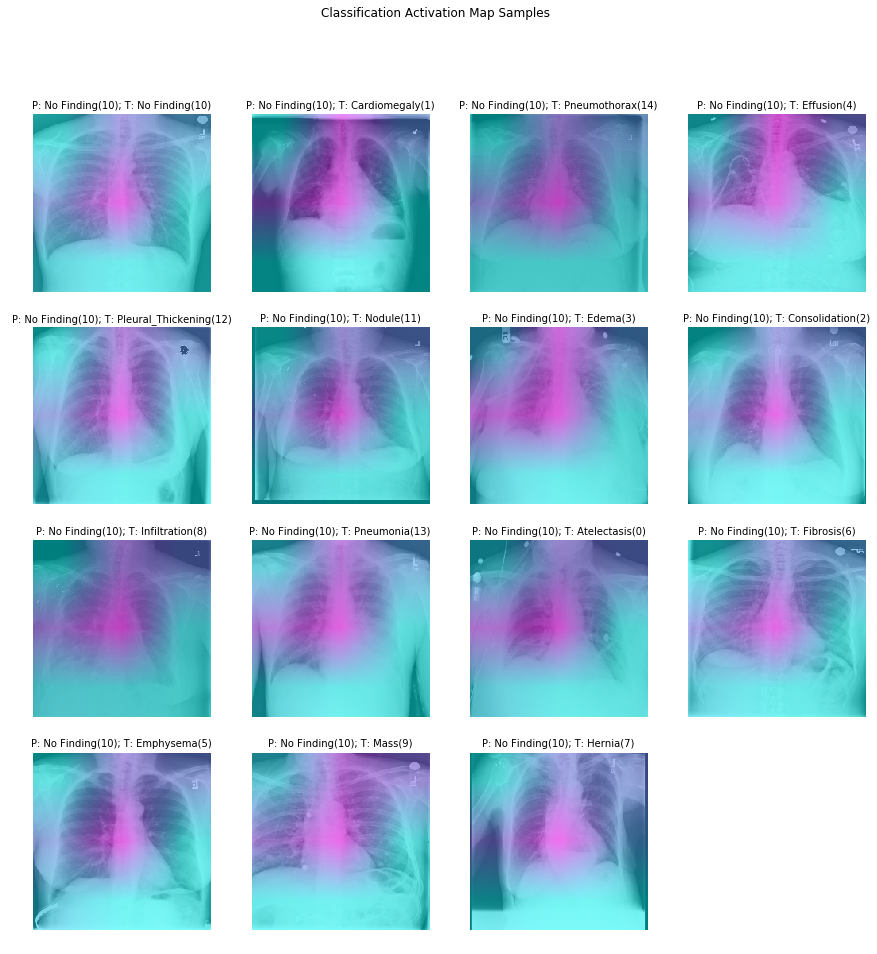

In [7]:

# load json and create model
with open('Top_FCN_Model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("Top_FCN_Model_weights.h5")
print("Loaded model from disk")

# load dataset in form of (224, 224)
hdf5_path_img = "Resampled_data.h5"

# open the h5 file to peek the number of rows of the dataset
with tables.open_file(hdf5_path_img, 'r') as data_set:
    N = len(data_set.root.preprocessed_data)
    y = data_set.root.label[:].ravel()

# Randomly shuffle the data
random_seed = 678
np.random.seed(random_seed)

# Create a randonly shuffled list of indices
perm = np.random.permutation(N)

# set both test data size and validation data size as 2500
test_size  = 2500
val_size   = 2500
train_size = N - test_size - val_size

test_idx  = perm[:test_size]
val_idx   = perm[test_size:test_size+val_size]
train_idx = perm[-train_size:]

# select the test subset from the dataset
with tables.open_file(hdf5_path_img, 'r') as data_set:
    X_test = data_set.root.preprocessed_data[test_idx, :, :, :]
    y_test = data_set.root.label[test_idx,:].ravel()

# load the bottleneck features created by VGG16 convolutional layers
test_data_features = np.load(open('bottleneck_features_224_224_test.npy'))

# layers of the loaded_model
l = loaded_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-3].output, l[-1].output])

# zip the bottleneck features and original dataset(in form of images) together as input
inps = zip(test_data_features, X_test, y_test)

# labels of the classes
labels_str = ['Atelectasis(0)','Cardiomegaly(1)', 'Consolidation(2)', 'Edema(3)','Effusion(4)', 'Emphysema(5)','Fibrosis(6)','Hernia(7)','Infiltration(8)', 'Mass(9)','No Finding(10)','Nodule(11)','Pleural_Thickening(12)','Pneumonia(13)','Pneumothorax(14)']


def get_cm(inps):
	"""This function takes three variables in a tuple inps:
	test_data_features: the bottleneck features using VGG16 convolutional layers on test dataset
	X_test: the raw test dataset
	y_test: the true labels
	"""
	# extend the 3d tensor (9, 16, 512) of test_data_features into 4d tensor (1, 9, 16, 512)
	inps_0 = np.expand_dims(inps[0], 0)

    # take a 4d tensore as input of compiled function conv_fn to compute the filters of last convolutional layer
	[conv_output, prediction] = conv_fn([inps_0, 0])
	pred_label = np.argmax(prediction)
	true_label = inps[-1]
	conv = conv_output[0,:,:,pred_label]

	# in OpenCV, image shape is in order of (width, height)
	return cv2.resize(conv, (224, 224)), inps[1], pred_label, true_label

def plot_cam(X):
	"""This function take a tuple including test_data_features, X_test and y_test as input
	"""
	activation, original_pic, pred_label, true_label = get_cm(X)
	pred_label = labels_str[pred_label]
	true_label = labels_str[true_label]
	ax.imshow(cv2.cvtColor(original_pic, cv2.COLOR_BGR2RGB))
	# plotting the class activation map (CAM)
	ax.imshow(activation, cmap='cool', alpha=0.5)
	ax.set_title('P: %s; T: %s' %(pred_label, true_label), fontsize=10)
	ax.axis('off')


### Examples

# create a list of length of test dataset
list_ = range(test_size)
# in-place shuffle
random.shuffle(list_)

def random_idx():
	"""This function is to randomly choose 15 image indices from test dataset;
	each indice corresponds to a unique true label
	"""
	# create a list of length of test dataset
	list_ = range(test_size)

	# in-place shuffle
	random.shuffle(list_)

	# to store the labels of randomly chosen indices
	random_list_labels = []
	# to store randomly chosen indices
	indices = []

	while True:
		# randomly choose one index from list_ at a time
		idx = random.choice(list_)

		# extract the true label
		chosen_labels = y_test[idx]

		# if the chosen true label is not in the list yet, add the label to the list
		# and add the idx into the indices list
		if chosen_labels not in random_list_labels:
			random_list_labels.append(chosen_labels)
			indices.append(idx)

		# if there are 15 indices that represent 15 unique true lables, stop the loop
		if len(indices) == 15:
			break

	return indices

random_idx = random_idx()
print random_idx
# plotting 8 imgs representing 8 unique classes

#fig, axes = plt.subplots(4, 4, figsize=(12,12))
#fig.subplots_adjust(hspace=0.1, wspace=0.05)
fig = plt.figure(figsize=(15,15))
plt.suptitle('Classification Activation Map Samples')

for i, ax in enumerate(range(len(labels_str))):
    ax = fig.add_subplot(4,4,i+1)
    plot_cam(inps[random_idx[i]])

